# Installing and importing Dependencies

In [1]:
!pip install tensorflow-gpu

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip install tensorflow-io

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import scipy.io.wavfile as wavfile
from scipy.signal import resample

# Data Loading

In [4]:
CAPUCHIN_FILE = os.path.join('Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
NOT_CAPUCHIN_FILE = os.path.join('Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')

In [5]:
CAPUCHIN_FILE

'Parsed_Capuchinbird_Clips\\XC3776-3.wav'

In [6]:
NOT_CAPUCHIN_FILE

'Parsed_Not_Capuchinbird_Clips\\afternoon-birds-song-in-forest-0.wav'

In [7]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = resample(wav, int(wav.shape[0] * 16000 / sample_rate))
    return wav

In [8]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

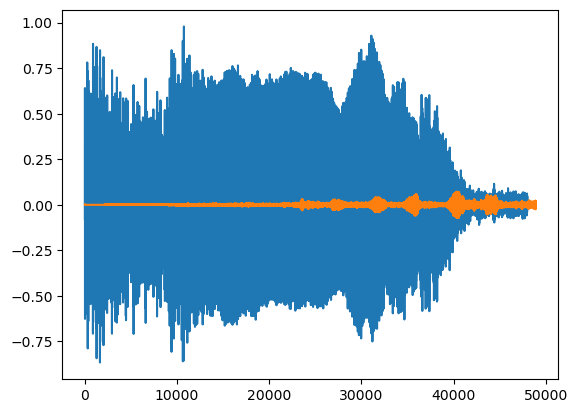

In [9]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# Creating the dataset 

In [10]:
Positives = os.path.join('Parsed_Capuchinbird_Clips')
Negatives = os.path.join('Parsed_Not_Capuchinbird_Clips')

In [11]:
Positives

'Parsed_Capuchinbird_Clips'

In [12]:
pos = tf.data.Dataset.list_files(Positives + '\\*.wav')
neg = tf.data.Dataset.list_files(Negatives + '\\*.wav')

In [14]:
pos.as_numpy_iterator().next()

b'Parsed_Capuchinbird_Clips\\XC227471-4.wav'

In [23]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))

In [25]:
print(len(positives))
print(len(negatives))

217
593


In [22]:
positives.as_numpy_iterator().next()

(b'Parsed_Capuchinbird_Clips\\XC456236-3.wav', 1.0)

In [26]:
negatives.as_numpy_iterator().next()

(b'Parsed_Not_Capuchinbird_Clips\\birds-singing-in-forest-sounds-53.wav', 0.0)

In [27]:
data = positives.concatenate(negatives)

In [28]:
print(len(data))

810


In [34]:
data.shuffle(1000).as_numpy_iterator().next()

(b'Parsed_Not_Capuchinbird_Clips\\night-insect-sounds-36.wav', 0.0)

# Calculating the average of the birds call 

In [36]:
lengths = []
for file in os.listdir(os.path.join('Parsed_Capuchinbird_Clips')):
    tensor_wave = load_wav_16k_mono(os.path.join('Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

In [39]:
lengths[0:5]

[40000, 48000, 56000, 48000, 56000]

In [41]:
len(lengths)

217

In [42]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [44]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [45]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

In [53]:
#Avg = lengths/Frequency
Highest_time = 80000/16000
Lowest_time = 32000/16000
Avg_time = 54156/16000
print(f'Highest duration of the birds call is: {Highest_time}s')
print(f'Lowest duration of the birds call is: {Lowest_time}s')
print(f'Average duration of the birds call is: {round(Avg_time,2)}s')

Highest duration of the birds call is: 5.0s
Lowest duration of the birds call is: 2.0s
Average duration of the birds call is: 3.38s


# Data Preprocessing

In [54]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [74]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [75]:
spectrogram, label = preprocess(filepath, label)

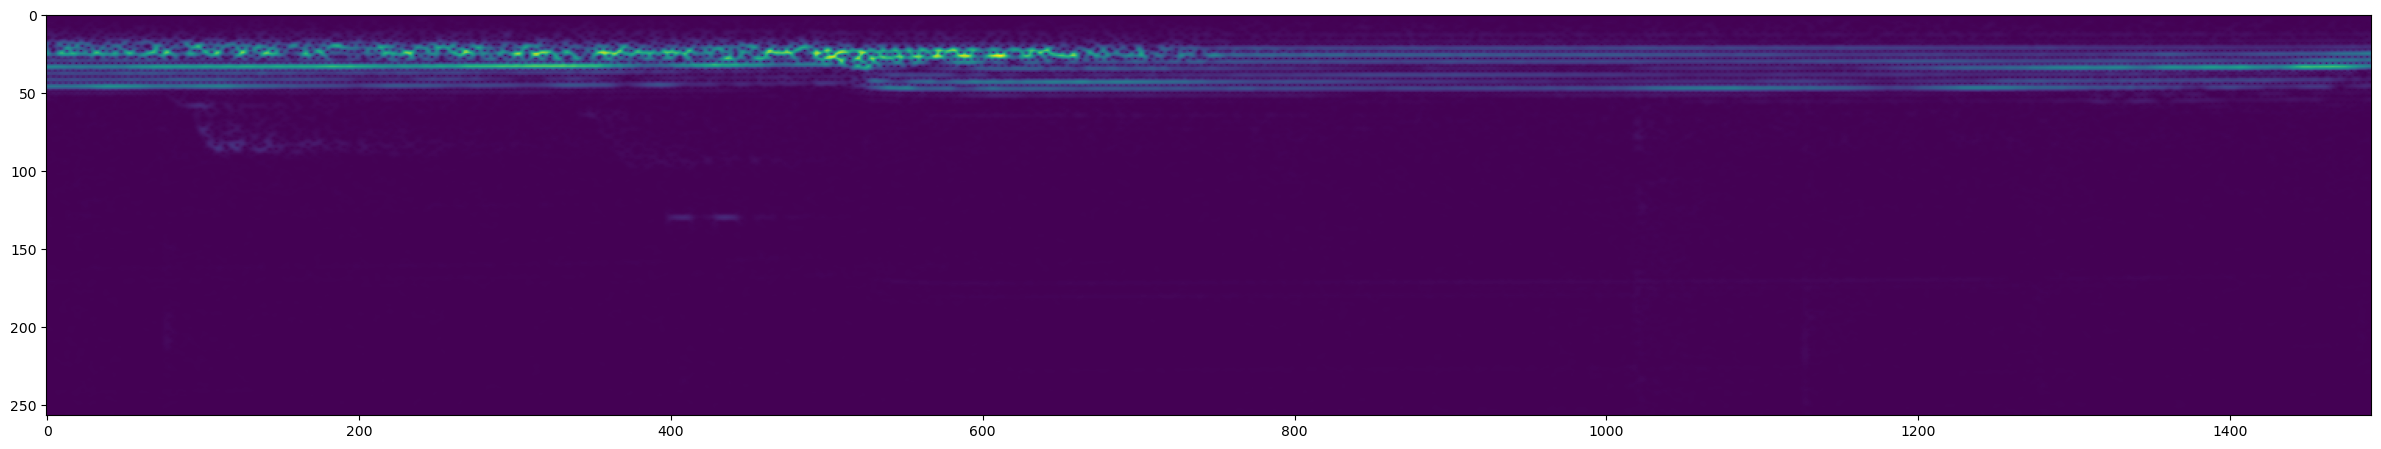

In [76]:
#Spectrogram of a capuchinbrid call
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [71]:
filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [72]:
spectrogram, label = preprocess(filepath, label)

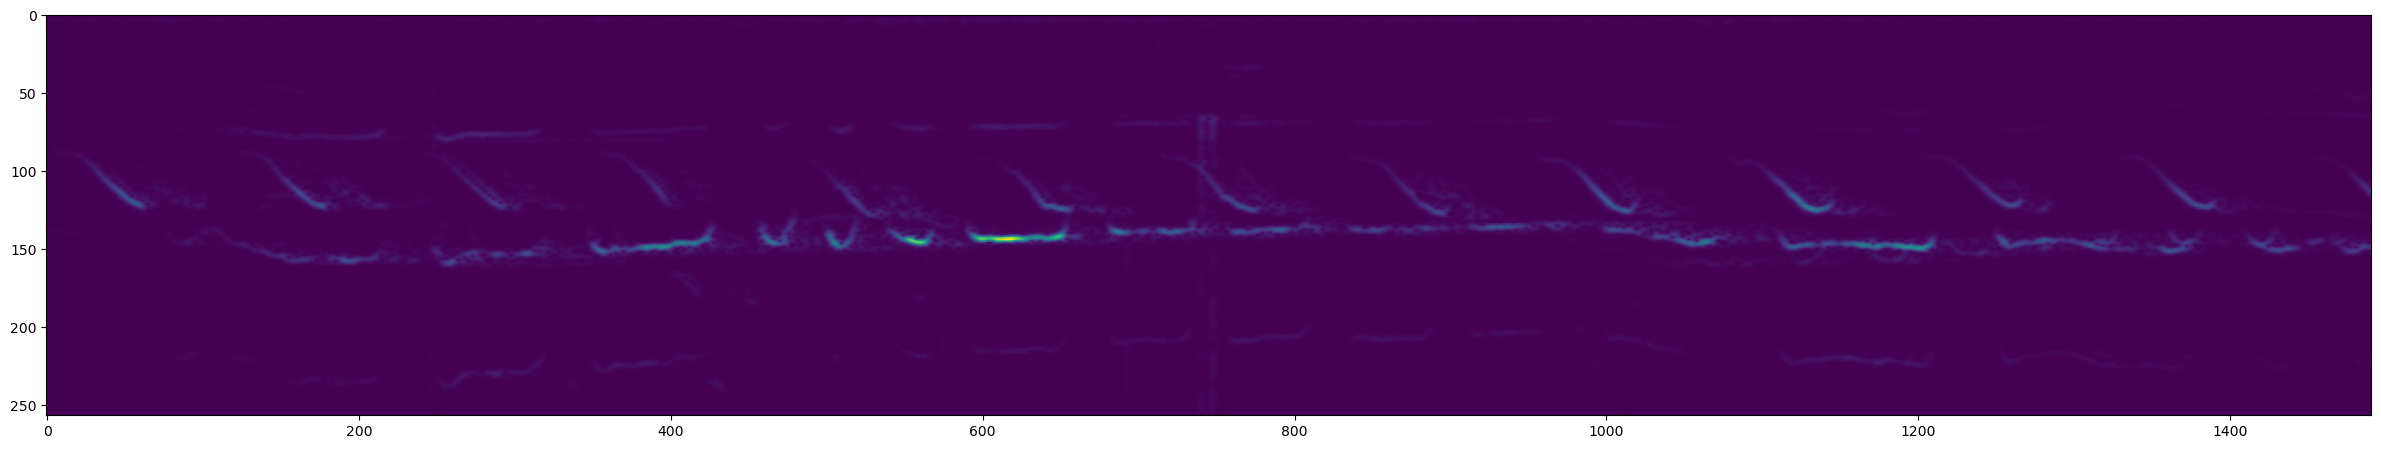

In [73]:
#Spectrogram of not a capuchinbrid call
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()